In [0]:
# Import relevant modules

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils import data as t_data
import torchvision.datasets as datasets
from torchvision import transforms

In [0]:
data_transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
emnist_trainset = datasets.EMNIST(root='./data', split='letters', train=True, download=True, transform=data_transforms)

In [30]:
# Define training batch size

batch_size=200
dataloader = t_data.DataLoader(emnist_trainset, batch_size=batch_size, shuffle=True)
print(len(dataloader))

624


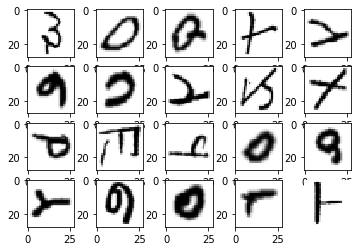

In [70]:
# View some images in the EMNIST dataset

for batch, _ in dataloader:
    fig, axs = plt.subplots(4, 5)
    for i in range(20):
        plot_img(batch[i], axs, int(i/5), i%5)
    plt.show()
    break


In [0]:
# Function to generate random noise (to be used as input to the Generator Network)

def noise(batch_size):
    return torch.randn(batch_size,100)

In [0]:
class Discriminator(nn.Module):
    """
    A two hidden-layer discriminative neural network
    """
    def __init__(self, n_features, n_out):
        super(Discriminator, self).__init__()
        
        # self.hidden0 = nn.Sequential( 
        #     nn.Linear(n_features, 1024),
        #     nn.LeakyReLU(0.2),
        # )
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 512),
            nn.LeakyReLU(0.2),
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        # x = self.hidden2(x)
        x = self.out(x)
        return x

In [0]:
# Define the generator class

class Generator(nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self, n_features, n_out):
        super(Generator, self).__init__()
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(num_features = 256, momentum = 0.8)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(num_features = 512, momentum = 0.8)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(num_features = 1024, momentum = 0.8)
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x


In [0]:
# Function to display images of real/generated images

def plot_img(array, ax, i, j):
    array = array.detach()
    array = array.reshape(28,28)
    array = array*0.5 + 0.5
    
    ax[i, j].imshow(array,cmap='binary')

In [0]:
# Function to train the discriminator

def train_discriminator(optimizer, loss, real_data, fake_data):
    N = real_data.size(0)
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    error_real = loss(prediction_real, Variable(torch.ones(N, 1)))
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, Variable(torch.zeros(N, 1)))
    error_fake.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error and predictions for real and fake inputs
    return error_real + error_fake, prediction_real, prediction_fake

In [0]:
# Function to train the generator

def train_generator(optimizer, loss, fake_data):
    N = fake_data.size(0)
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    error = loss(prediction, Variable(torch.ones(N, 1)))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

In [0]:
# Create the discriminator & generator objects
discriminator = Discriminator(784, 1)
generator = Generator(100, 784)

# Define Loss functions & Optimizers
loss = nn.BCELoss()
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002)
optimizer_g = optim.Adam(generator.parameters(), lr=0.0002)

In [0]:
# Generate noise samples to act as validation data (to view at the end of every epoch)

num_validation_samples = 20
validation_noise = noise(num_validation_samples)


# To store generator & discriminator errors (will be plotted later)

g_err = []
d_err = []

In [0]:
# Train both the networks simultaneously

epochs = 200

for epoch in range(epochs):
    print("Epoch: %d" %(epoch))
    for n_batch, (real_batch,_) in enumerate(dataloader):
        N = real_batch.size(0)
        # 1. Train Discriminator
        real_data = real_batch.reshape(batch_size,784)
        # Generate fake data and detach 
        # (so gradients are not calculated for generator)
        fake_data = generator(noise(batch_size))
        # Train D
        d_error, d_pred_real, d_pred_fake = train_discriminator(optimizer_d, loss, real_data, fake_data)

        # 2. Train Generator
        # Generate fake data
        fake_data = generator(noise(batch_size))
        # Train G
        g_error = train_generator(optimizer_g, loss, fake_data)
        # Log batch error
        
        # logger.log(d_error, g_error, epoch, n_batch, num_batches)
        # Display Progress every few batches
        if (n_batch + 1) % 100 == 0 or n_batch == 0: 
            print("\tBatch: %d\tDiscriminator Error: %f\tGenerator Error: %f" %(n_batch + 1, d_error, g_error))
            g_err.append(g_error)
            d_err.append(d_error)
        if (n_batch + 1) % 624 == 0:
            g_err.append(g_error)
            d_err.append(d_error)
            validation_images = generator(validation_noise)
            fig, axs = plt.subplots(4, 5)
            for i in range(20):
                plot_img(validation_images[i], axs, int(i/5), i%5)
            plt.show()

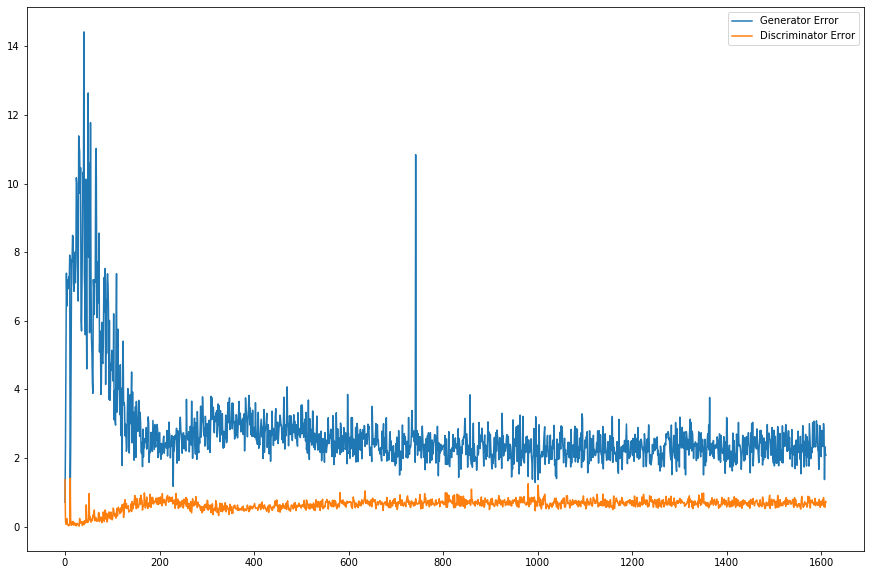

In [55]:
# Plot the discriminator & generator errors with training time

plt.figure(figsize=(15, 10))
plt.plot(g_err, label="Generator Error")
plt.plot(d_err, label="Discriminator Error")
plt.legend()
plt.show()


In [0]:
# Save the generator & discriminator model states
torch.save(generator.state_dict(), 'emnist_generator')
torch.save(discriminator.state_dict(), 'emnist_discriminator')

In [58]:
# Load the Generator Model
gen = Generator(100, 784)
gen.load_state_dict(torch.load('emnist_generator'))
gen.eval()

Generator(
  (hidden0): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
  )
  (hidden1): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): BatchNorm1d(512, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
  )
  (hidden2): Sequential(
    (0): Linear(in_features=512, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): BatchNorm1d(1024, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
  )
  (out): Sequential(
    (0): Linear(in_features=1024, out_features=784, bias=True)
    (1): Tanh()
  )
)

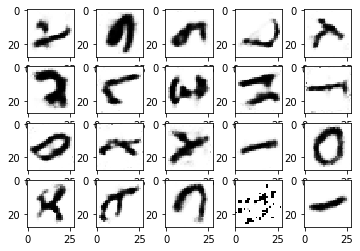

In [69]:
# Test the generator

test_images = gen(noise(20))
fig, axs = plt.subplots(4, 5)
for i in range(20):
    plot_img(test_images[i], axs, int(i/5), i%5)
plt.show()